In [1]:
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn. cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [2]:
from rmp_preprocess import ReviewPreprocessor

In [3]:
df_raw = pd.read_csv("rmp_all_schools_reviews_small.csv")
processor = ReviewPreprocessor()
df = processor.preprocess(df_raw)
comments = df["comment_clean"].tolist()
df.head()


,clarityRating,class,comment,date,difficultyRating,legacyId,ratingTags,profId,comment_no_numbers,comment_clean,...,tag_respected,tag_respected_by_students,tag_so_many_papers,tag_skip_class_you_won_t_pass,tag_test_heavy,tag_tests_are_tough,tag_tests_not_many,tag_tough_grader,tag_would_take_again,labeled
0,1,Math32A,This was the absolute worst math class of my l...,2026-02-10 04:20:05 +0000 UTC,5,42598787,Tough grader--Test heavy,3145448,This was the absolute worst math class of my l...,This was the absolute worst math class of my l...,...,0,0,0,0,1,0,0,1,0,True
1,1,Math32A,If I can save you from the torture of a lifeti...,2026-02-10 01:35:28 +0000 UTC,5,42598200,Tough grader,3145448,If I can save you from the torture of a lifeti...,If I can save you from the torture of a lifeti...,...,0,0,0,0,0,0,0,1,0,True
2,1,Math32A,Get ready for the biggest GPA tank of ur life....,2026-02-02 03:51:34 +0000 UTC,5,42573402,Tough grader--Test heavy--Graded by few things,3145448,Get ready for the biggest GPA tank of ur life....,Get ready for the biggest GPA tank of ur life....,...,0,0,0,0,1,0,0,1,0,True
3,1,Math32A,3 midterms with 20% each and a final worth 40%...,2026-01-28 04:24:59 +0000 UTC,4,42557851,Tough grader--Test heavy--Graded by few things,3145448,midterms with % each and a final worth % of to...,midterms with % each and a final worth % of to...,...,0,0,0,0,1,0,0,1,0,True
4,1,Math32A,His a good person since he is willing to help ...,2026-01-28 04:22:44 +0000 UTC,5,42557841,Tough grader--Test heavy,3145448,His a good person since he is willing to help ...,His a good person since he is willing to help ...,...,0,0,0,0,1,0,0,1,0,True


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

domain_stopwords = {
    "class", "classes", "course", "courses",
    "professor", "professors", "prof", "teacher", "teaching", "teaches", "taught",
    "lecture", "lectures",
    "student", "students",
    "material", "concepts",
    "exam", "exams", "midterm", "final", "finals", "quiz", "quizzes",
    "homework", "assignment", "assignments",
    "grade", "grades", "grading",
    "office", "hours",
    "reading", "readings", "book", "books", "notes",
    "ucla", "dr", "%"
}

all_stopwords = ENGLISH_STOP_WORDS.union(domain_stopwords)

vectorizer = TfidfVectorizer(
    lowercase=True,
    norm="l2",
    binary=True,
    token_pattern=r"(?u)\b\w{3,}\b",
    strip_accents="unicode",
    stop_words=list(all_stopwords),
    ngram_range=(1,3),
    min_df=200,
    max_df=0.6,
    sublinear_tf=True,
    max_features=200_000,
    analyzer="word"
)

comment_tfidf = vectorizer.fit_transform(comments)

print(comment_tfidf.shape)
print(vectorizer.get_feature_names_out())


(458059, 5603)
['abilities' 'ability' 'able' ... 'zone' 'zoom' 'zybooks']


Best k (by min reconstruction error): 10


,k,reconstruction_err
0,1,670.315408
1,2,668.791865
2,3,667.477412
3,4,666.169817
4,5,665.047702
5,6,664.034343
6,7,663.020771
7,8,662.094637
8,9,661.193564
9,10,660.289488


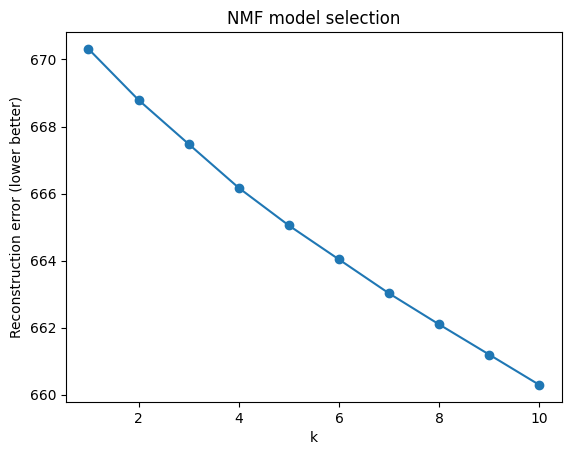

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

X = comment_tfidf.tocsr()

rows = []
for k in range(1, 11):
    nmf = NMF(
        n_components=k,
        init="nndsvda",
        random_state=42,
        max_iter=800,
        solver="cd",
        beta_loss="frobenius"
    )
    W = nmf.fit_transform(X)
    rows.append({"k": k, "reconstruction_err": nmf.reconstruction_err_})

metrics = pd.DataFrame(rows)
best_k = int(metrics.loc[metrics["reconstruction_err"].idxmin(), "k"])

print("Best k (by min reconstruction error):", best_k)
display(metrics)

plt.plot(metrics["k"], metrics["reconstruction_err"], marker="o")
plt.xlabel("k")
plt.ylabel("Reconstruction error (lower better)")
plt.title("NMF model selection")
plt.show()


In [7]:
best_k=5

In [8]:
from sklearn.decomposition import NMF

X = comment_tfidf.tocsr()
feature_names = vectorizer.get_feature_names_out()

final_nmf = NMF(
    n_components=best_k,
    init="nndsvda",
    random_state=42,
    max_iter=800,
    solver="cd",
    beta_loss="frobenius"
)

W_final = final_nmf.fit_transform(X)
H_final = final_nmf.components_

df["nmf_topic"] = W_final.argmax(axis=1)
df["nmf_topic_strength"] = W_final.max(axis=1)

print(f"Using best_k = {best_k}")
print("\nTop words per topic:")
for t in range(best_k):
    top_ids = H_final[t].argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_ids]
    print(f"Topic {t}: {', '.join(top_words)}")

# Representative comments = comments with highest membership weight in each topic.
n_examples = 3
print("\nRepresentative comments per topic:")
for t in range(best_k):
    topic_mask = df["nmf_topic"] == t
    topic_df = df.loc[topic_mask, ["comment_clean", "nmf_topic_strength"]].copy()
    topic_df = topic_df.sort_values('nmf_topic_strength', ascending=False).head(n_examples)

    print(f"\n=== Topic {t} (n={topic_mask.sum()}) ===")
    if topic_df.empty:
        print("No comments assigned.")
        continue

    for i, (_, row) in enumerate(topic_df.iterrows(), start=1):
        comment = str(row["comment_clean"]).strip().replace('\n', ' ')
        print(f"{i}. [{row['nmf_topic_strength']:.4f}] {comment}")

df[['comment_clean', 'nmf_topic', 'nmf_topic_strength']].head(10)



Using best_k = 5

Top words per topic:
Topic 0: hard, tests, just, don, questions, like, time, difficult, study, understand
Topic 1: great, great lecturer, lecturer, great guy, great really, overall great, really great, great great, overall, clear
Topic 2: best, far, taken, davis, math, best math, best taken, uci, far best, ucsd
Topic 3: good, really good, good lecturer, lecturer, pretty good, pretty, overall, good luck, luck, overall good
Topic 4: easy, really, interesting, recommend, nice, helpful, super, lot, fun, amazing

Representative comments per topic:

=== Topic 0 (n=178388) ===
1. [0.0360] Tests are soooooooo hard
2. [0.0316] The tests were always hard, but to manage above-average grades on the three midterms, I reviewed all the slides and did all the textbook practice problems. She does not curve and you are better off not attending her horrible lectures. Teach yourself and review every textbook problem because test and quiz questions are the same. Do this and get an A
3. [0

,comment_clean,nmf_topic,nmf_topic_strength
0,This was the absolute worst math class of my l...,0,0.014298
1,If I can save you from the torture of a lifeti...,0,0.014214
2,Get ready for the biggest GPA tank of ur life....,0,0.012357
3,midterms with % each and a final worth % of to...,0,0.005536
4,His a good person since he is willing to help ...,0,0.017510
5,"I dont know where they get this guy, just stay...",0,0.009863
6,"midterms and final for entire grade, but allow...",0,0.014607
7,"He's nice and answers questions! That said, I ...",0,0.015566
8,"Yes this guy is HARD, but he teaches you grit ...",0,0.015068
9,Tests are very difficult. Much more content is...,3,0.016909


In [9]:
output_csv = "Reviews_clustered_NMF5.csv"
#df.to_csv(output_csv, index=False)
print(f"Saved {output_csv} with shape {df.shape}")
df[["comment_clean", "nmf_topic", "nmf_topic_strength"]].head()


Saved Reviews_clustered_NMF5.csv with shape (458059, 40)


,comment_clean,nmf_topic,nmf_topic_strength
0,This was the absolute worst math class of my l...,0,0.014298
1,If I can save you from the torture of a lifeti...,0,0.014214
2,Get ready for the biggest GPA tank of ur life....,0,0.012357
3,midterms with % each and a final worth % of to...,0,0.005536
4,His a good person since he is willing to help ...,0,0.017510
